In [1]:

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

def subset_data(Y, E, G, start_index=0, end_index=10000):
    """
    Subset the data to a smaller sample for faster processing.
    
    Parameters:
    Y: Disease outcome tensor
    E: Censoring matrix
    G: Genetic data matrix
    start_index: Starting index for subset
    end_index: Ending index for subset
    
    Returns:
    Y_subset, E_subset, G_subset, indices: Subsetted data and indices
    """
    indices = list(range(start_index, min(end_index, Y.shape[0])))
    Y_subset = Y[indices]
    E_subset = E[indices]
    G_subset = G[indices]
    return Y_subset, E_subset, G_subset, indices


%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
from fig5utils import *
%load_ext autoreload
%autoreload 2
import torch


# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


# Load and initialize model:
Y, E, G, essentials = load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
# When initializing the model:
original_G = G # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/Users/sarahurbut/aladynoulli2/pyScripts/fig5utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/Users/sarahurbut/aladynoul

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_4272/2363405654.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L

In [77]:
def load_covariates_data(csv_path):
    """Load and process covariates from CSV file"""
    print("Loading covariates data...")
    fh_processed = pd.read_csv(csv_path)

    # Convert sex to numeric: Female=0, Male=1
    if 'Sex' in fh_processed.columns:
        fh_processed['sex_numeric'] = fh_processed['Sex'].map({'Female': 0, 'Male': 1}).astype(int)
        sex = fh_processed['sex_numeric'].values
    elif 'sex' in fh_processed.columns:
        # If already numeric or lowercase
        sex = fh_processed['sex'].values
    else:
        raise ValueError("No 'Sex' or 'sex' column found in covariates CSV")

    return sex, fh_processed


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



# Subset the data
Y_batch, E_batch, G_batch, indices = subset_data(Y, E, G,
                                                    start_index=0,
                                                    end_index=10000)


# Load covariates data and subset it
sex, fh_processed = load_covariates_data('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv')
sex_batch = sex[0:10000]

# Combine G with sex
G_with_sex = np.column_stack([G_batch, sex_batch])
pc_columns = ['f.22009.0.1', 'f.22009.0.2', 'f.22009.0.3', 'f.22009.0.4', 'f.22009.0.5','f.22009.0.6', 'f.22009.0.7', 'f.22009.0.8', 'f.22009.0.9', 'f.22009.0.10']
pcs = fh_processed.iloc[0:10000][pc_columns].values
G_with_sex = np.column_stack([G_batch, sex_batch, pcs])
#G_with_sex = np.column_stack([G_batch, sex_batch])
print(f"G_with_sex shape: {G_with_sex.shape}")
print(f"Covariates loaded: {fh_processed.shape[0]} total samples")


Loading covariates data...
G_with_sex shape: (10000, 47)
Covariates loaded: 407878 total samples


In [ ]:
from fig5utils import *
checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_0_10000.pt'

#checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi/model_enroll_fixedphi_sex_0_10000.pt'
#checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
checkpoint = torch.load(checkpoint_path)
checkpoint['model_state_dict']['gamma'].shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_92433/1809615987.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


torch.Size([37, 21])

In [83]:
from fig5utils import *
checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_0_10000.pt'
#checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi/model_enroll_fixedphi_sex_0_10000.pt'
#checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_fulldata_sexspecific.pt'
checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_0_10000.pt'
checkpointpcs = torch.load(checkpoint_path)
checkpointpcs['model_state_dict']['gamma'].shape


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_92433/829979368.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpointpcs = torch.load(checkpoint_path)


torch.Size([47, 21])

In [84]:

Y_100k, E_100k, G_100k, indices = subset_data(Y,E,G, start_index=0, end_index=10000)
G_100k=G_with_sex
torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
model.load_state_dict(checkpointpcs['model_state_dict'])

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_92433/406732239.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/C


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0026,  0.0050,  0.0103,  0.0132, -0.0116])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

<All keys matched successfully>

In [ ]:
import glob, torch
from utils import compare_with_pce#
cov_df=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')

ckpt_paths = sorted(glob.glob(
    "/Users/sarahurbut/Library/CloudStorage/Dropbox/"
    "enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/"
    "model_enroll_fixedphi_sex_*_*.pt"
))

all_metrics = []

from utils import compare_with_pce

for path in ckpt_paths:
    ckpt = torch.load(path)
    
    start_index = ckpt["start_index"]
    end_index = ckpt["end_index"]
    cov_batch = cov_df.iloc[start_index:end_index]


    lambda_ = ckpt["model_state_dict"]["lambda_"]
    phi = ckpt["model_state_dict"]["phi"]
    kappa = ckpt["model_state_dict"]["kappa"]
    Y_batch = Y[start_index:end_index].numpy()

    metrics = compare_with_pce(
        
        cov_df=cov_batch,
        Y=Y_batch,
        ascvd_indices=[111, 112, 113, 114, 115, 116],
        # pass any other kwargs your helper expects, e.g. mu_dt, calibrator, etc.
    )
    all_metrics.append(metrics)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_4272/1998679678.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


TypeError: compare_with_pce() got an unexpected keyword argument 'lambda_'

In [1]:
import glob
import numpy as np
import pandas as pd
import torch
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import roc_auc_score

# 1) Load full covariate and outcome matrices once
cov_df = pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv")
Y_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt")

def evaluate_checkpoint(ckpt, cov_batch, Y_batch, ascvd_indices, pce_col="pce_goff_full"):
    state = ckpt["model_state_dict"]
    lambda_ = state["lambda_"]                      # (N, K, T)
    phi = state["phi"]                              # (K, D, T)
    kappa = state["kappa"]                          # scalar or (1,)
    theta = torch.softmax(lambda_, dim=1)
    phi_prob = torch.sigmoid(phi)
    pi = torch.einsum("nkt,kdt->ndt", theta, phi_prob) * kappa
    pi_np = pi.detach().cpu().numpy()
    Y_np = Y_batch

    pred_mean = pi_np.mean(axis=0).flatten()
    obs_mean = Y_np.mean(axis=0).flatten()
    order = np.argsort(pred_mean)
    smoothed = lowess(obs_mean[order], pred_mean[order], frac=0.3)
    pi_calibrated = np.interp(pi_np.flatten(), smoothed[:,0], smoothed[:,1],
                              left=smoothed[0,1], right=smoothed[-1,1]).reshape(pi_np.shape)

    our_10yr, actual_10yr, pce = [], [], []
    n_time = pi_np.shape[2]
    for idx, row in enumerate(cov_batch.itertuples()):
        enroll_t = int(getattr(row, "age") - 30)
        if enroll_t < 0 or enroll_t + 10 >= n_time:
            continue
        preds = pi_calibrated[idx, ascvd_indices, enroll_t]
        yearly_risk = 1 - np.prod(1 - preds)
        our_10yr.append(1 - (1 - yearly_risk) ** 10)
        window = Y_np[idx, ascvd_indices, enroll_t:enroll_t + 10]
        actual_10yr.append((window > 0).any())
        pce.append(getattr(row, pce_col))

    our_10yr = np.array(our_10yr)
    actual_10yr = np.array(actual_10yr, dtype=int)
    pce = np.array(pce)
    return {
        "our_auc": roc_auc_score(actual_10yr, our_10yr),
        "pce_auc": roc_auc_score(actual_10yr, pce),
        "n": len(actual_10yr),
    }

# 2) Loop over all fixed-φ checkpoints
ckpt_paths = sorted(glob.glob(
    "/Users/sarahurbut/Library/CloudStorage/Dropbox/"
    "enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/"
    "model_enroll_fixedphi_sex_*_*.pt"
))
metrics = []
ascvd_idx = [111, 112, 113, 114, 115, 116]

for path in ckpt_paths:
    ckpt = torch.load(path)
    start = ckpt["start_index"]
    end = ckpt["end_index"]
    cov_batch = cov_df.iloc[start:end]
    Y_batch = Y_full[start:end].numpy()
    metrics.append(evaluate_checkpoint(ckpt, cov_batch, Y_batch, ascvd_idx))

# 3) Aggregate results across batches
weighted_auc = np.average(
    [m["our_auc"] for m in metrics],
    weights=[m["n"] for m in metrics]
)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_66498/3692475147.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y_full = torch.load("/Users/sarahurbut/Libra

AttributeError: 'Pandas' object has no attribute 'age'


ROC AUC Comparison (10-year prediction from enrollment):
Our model: 0.712
PCE: 0.678


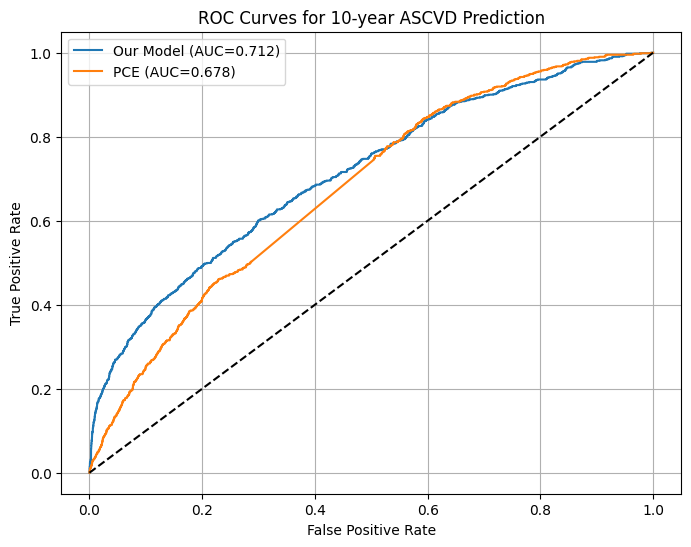

In [85]:
from utils import *
model.load_state_dict(checkpointpcs['model_state_dict'])
#Evaluate Baseline Models on TEST data <-- UNCOMMENT THIS
compare_with_pce(model, pce_df, ascvd_indices=[111,112,113,114,115,116])

In [ ]:
from sre_parse import CHCODES


aladynoulli_results_boot_enrolle = evaluate_major_diseases_wsex_with_bootstrap(model, Y_100k, E_100k, model.disease_names, pce_df, n_bootstraps=20, follow_up_duration_years=10)
# 6. 



Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.683 (0.671-0.702) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.669, Events = 273/5409
   Male: AUC = 0.685, Events = 558/4591

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.707, Events = 8/37
   Breast_Cancer: AUC = 0.549, Events = 13/170

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.613 (0.593-0.626) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.604, Events = 264/5409
   Male: AUC = 0.617, Events = 317/4591

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.701 (0.671-0.726) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)
Excluded 13

## interesting, seems better using joint phi that has 

In [31]:
from fig5utils import *
checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/enrollment_model_W0.0001_jointphi_sexspecific.pt'
#checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/resultshighamp/results/output_0_10000/model.pt'
checkpoint = torch.load(checkpoint_path)


original_G = G # Store the original G - proper tensor copy

Y_100k, E_100k, G_100k, indices = subset_data(Y,E,G, start_index=0, end_index=10000)
G_100k=checkpoint['G']
torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
model.load_state_dict(checkpoint['model_state_dict'])

aladynoulli_results_boot_enrolle = evaluate_major_diseases_wsex_with_bootstrap(model, Y_100k, E_100k, model.disease_names, pce_df, n_bootstraps=20, follow_up_duration_years=10)
# 6. 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_92433/3279340081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/Use


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0008,  0.0071,  0.0117,  0.0152, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered